# Facial Recognition Deep Learning

### Installing Dependencies

In [1]:
# %pip install opencv-python matplotlib tensorflow-macos

# tensorflow~=2.6.0 and tensorflow-gpu==2.6.0 for non mac users


## Importing Libraries

In [2]:
%%time
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import uuid
# tensorflow functional apis
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

CPU times: user 5.52 s, sys: 949 ms, total: 6.46 s
Wall time: 10.5 s


In [3]:
# Input & Output Model Look Like
#Model(input=[inputimgage, verificationImage], output=[1,0])


### GPU GROWTH (LIMIT GPU)
##### DON'T USE THIS COMMAND IF YOU DON'T HAVE GPU ON YOUR DEVICE

In [4]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


#### Folder Structure 

In [5]:
# specifying folder path
POSITIVE_PATH = os.path.join('data', 'positive')
NEGATIVE_PATH = os.path.join('data', 'negative')
ANCHOR_PATH = os.path.join('data', 'anchor')
# creating the folders
# os.makedirs(POSITIVE_PATH)
# os.makedirs(NEGATIVE_PATH)
# os.makedirs(ANCHOR_PATH)


## Collect Dataset (Positive and Anchor)

In [6]:
# decompress Tar GZ file
# !tar -xf lfw.tgz


In [7]:
# Move Images to Data/Negative
# for dir in os.listdir('lfw'):
#     # to get the inside folder paths
#     for file in os.listdir(os.path.join('lfw',dir)):
#         exact_path = os.path.join('lfw',dir,file)
#         new_path = os.path.join(NEGATIVE_PATH,file)
#         os.replace(exact_path,new_path)


In [8]:
# !rm -rf lfw


## Collect Positive and Anchor Class

### VideoCapture CV2 

In [9]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

#resolution set to base level, 640x480, 1280x720
cap.set(3, 640)
cap.set(4, 480)

while cap.isOpened():
    ret, frame = cap.read()

    # Cutting down frame to 250x250 px (last we have used (:) for getting all the colors)
    frame = frame[120:120+250, 200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create a Unique file Path
        img_name = os.path.join(ANCHOR_PATH, f"{uuid.uuid1()}.jpg")
        # write image to anchor folder
        cv2.imwrite(img_name, frame)

    # Collect Positive
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create a Unique file Path
        img_name = os.path.join(POSITIVE_PATH, f"{uuid.uuid1()}.jpg")
        # Write image to positive folder
        cv2.imwrite(img_name, frame)

    # Display the resulting frame
    cv2.imshow('Face Capture', frame)

    # Press Q on keyboard to stop recording
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# When everything done, release the video capture and video write objects
cap.release()
cv2.waitKey(1)
# Closes all the frames
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## Loading and Preprocessing Images

#### Get Image Directories

In [10]:
%%time
# Here Collect image from a specific path contain .jpg extension files upto 300
anchor = tf.data.Dataset.list_files(ANCHOR_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POSITIVE_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEGATIVE_PATH+'/*.jpg').take(300)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

CPU times: user 75.3 ms, sys: 304 ms, total: 380 ms
Wall time: 151 ms


2023-02-19 17:12:21.790832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-19 17:12:21.791462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
dir_test = anchor.as_numpy_iterator()

In [26]:
dir_test.next()

b'data/anchor/688d9ca4-af7a-11ed-a26e-6e6b8c2589e1.jpg'

## Preprocessing Scale and Resize

In [27]:
def preprocess(file_path):
    # Read Image from file path
    byte_img = tf.io.read_file(file_path)
    # Load image and decoding
    img = tf.io.decode_jpeg(byte_img)
    # preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img,(100,100))
    # scale image between 0 and 1
    img = img / 255.0
    return img 

In [28]:
test_img = preprocess("data/anchor/688d9ca4-af7a-11ed-a26e-6e6b8c2589e1.jpg")

In [31]:
test_img.numpy().max()

0.9752452

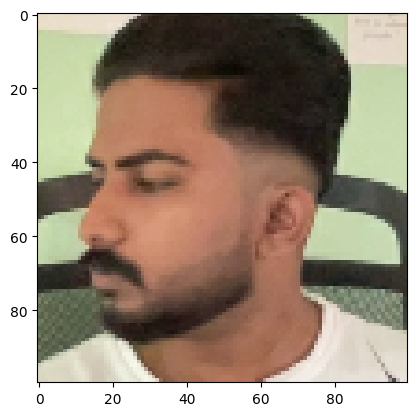

In [29]:
plt.imshow(test_img)

### Create Labelled Dataset

In [34]:
# (anchor, positive) = 1,1,1,1,1
# (anchor, negative) = 0,0,0,0,0

positive = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negative = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

In [35]:
data = positive.concatenate(negative)

In [37]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [38]:
samples = data.as_numpy_iterator()

In [39]:
samples.next()

(b'data/anchor/5b39d658-af7a-11ed-a26e-6e6b8c2589e1.jpg',
 b'data/positive/26dccab4-af7a-11ed-a26e-6e6b8c2589e1.jpg',
 1.0)

: 